# Project 1: Web scraping and basic summarization
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*

The goal of this project is to automatically retrieve structured data from page [rtvslo.si](https://www.rtvslo.si) for search terms "rusija" and "ukrajina". For both search terms each news article was parced and the data was expored to JSON file format.

## Environment setup

- Libraries needed to run this notebook are: numpy, matplotlib and selenium.

- Run the following commands to set up the environment:
 
> conda create -n project1_env python=3.9

> conda activate project1_env
 
> conda install -y numpy
 
> conda install -y matplotlib
  
> conda install -y selenium

- Or use project1_env.yml file from the same GitHub repository to setup the enviroment with command:

>conda create -f project1_env.yml`

- Also, for this project chrome driver was used, which was downloaded from the https://chromedriver.chromium.org/downloads.

In [1]:
# Loading all the libraries needed for running the code chunks below

import json
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchWindowException 


## Web scraping

Functions in this code do the following: a) programatically open rtv.slo.si page, b) sequentially enter search term 'ukrajina' and 'rusija', c) iterate through all the results and make a list of all the article links, d) go through the list of links of all articles and parse each article.


An example of Web pages from rtvslo.si:

<table>
    <tr>
        <td style="text-align: left;">rtvslo.si search results page</td>
        <td style="text-align: left;">rtvslo.si news article page</td>
    </tr>
    <tr>
        <td><img src="./rtvslo1.png" /></td>
        <td><img src="./rtvslo2.png" /></td>
    </tr>
</table>


Data extracted in this project was exported in a JSON format, that contains following information for every article: name of the author, date and time of publishment, title, subtitle, headline, text content, information if the article contains a video or not, tags and number of comments on the article.

JSON Schema of the data:

```
[  
  {
    "author": "G. K., Al. Ma.",
    "datetime_published": "3. november 2022 ob 19:57",
    "title": "Logar: Sem proti ostremu dialogu. Pirc Musar: Če vam to uspe znotraj stranke, dobite odlikovanje.",
    "subtitle": "Soočenje 2. kroga predsedniških volitev na TV Slovenija",
    "headline": "V prvem soočenju drugega kroga predsedniških volitev sta kandidata Nataša Pirc Musar in Anže Logar med drugim predstavljala svoja stališča glede vojne v Ukrajini in prihodnosti, ki jo prinaša, glede draginje in ukrepov vlade ter drugih aktualnih tem.",
    "content": "Teme pogovora so bile narodna sprava, naložbe v Slovensko vojsko, trenutne razmere in vladni ukrepi. Dotaknila sta se tudi naraščajočega verbalnega in fizičnega nasilja v družbi, imenovanj in kadrovanj, za katera bosta kot predsednica oz. predsednik pristojna, odnosa do evropske enotnosti ter vrednot v družbi... ",
    "video(yes/no)": "yes",
    "tags": [
      "Nataša Pirc Musar",
      "Anže Logar",
      "soočenje"
    ],
    "comments_num": 362
  },
  {
    ...
]
```

### Functions

In [9]:
# Implementation of search results page parsing 

# Function parse_search_results takes as arguments url of the current page and list of links of the articles from the 
# previous pages. It goes through the current page, finds links of all the articles from the current page and appends them
# to the list of links from the previous pages. Function returns list of links and url of the next page.


def parse_search_results(url, links):
    
    driver.get(url)
    driver.implicitly_wait(1)
    html = driver.page_source
    
    # finding links of all articles on the current page   
    for md in driver.find_elements(By.CLASS_NAME, 'md-news'):
        link = md.find_element(By.TAG_NAME, 'a')
        href = link.get_attribute('href')
        if href:
            links.append(href)
            
    # finding next page link  
    for pl in driver.find_elements(By.CLASS_NAME, "page-link"):
        next_page_url = pl.get_attribute('href')
    
    return links, next_page_url

In [10]:
# Implementation of news article page parsing

# Function parse_news_article takes as an argument url of one article, parses the article collecting the following data: name 
# of the author, date and time of publishment, title, subtitle, headline, text content, infromation if the article has the
# video or not and the number of comments. Function returns a dictionary that contains all of this data for one article.


def parse_news_article(url):   
    
    news_article_data = {'author':'','datetime_published':'','title': '','subtitle':'','headline':'','content':'','video(yes/no)':'','tags':'','comments_num':''}

    driver.get(url)
    driver.implicitly_wait(1)
    html = driver.page_source
    
    # finding the name of the author
    try:
        author = driver.find_element(By.CLASS_NAME, 'author')
        news_article_data['author'] = author.text
    except NoSuchElementException:
        news_article_data['author'] = 'Unknown author'
        
    # finding date and time of publishment  
    try:
        date = driver.find_element(By.CLASS_NAME, 'publish-meta')
        datetime = date.text.split('\n')
        news_article_data['datetime_published'] = datetime[0]
    except NoSuchElementException:
        news_article_data['datetime_published'] = 'Unknown date'
    
    # finding the title
    try:
        header = driver.find_element(By.CLASS_NAME, 'article-header')
        title = header.find_element(By.TAG_NAME, 'h1')
        news_article_data['title'] = title.text
    except NoSuchElementException:
        news_article_data['title'] = 'No title'
    
    # findinh the subtitle
    try:
        subtitle = driver.find_element(By.CLASS_NAME, 'subtitle')
        news_article_data['subtitle'] = subtitle.text
    except NoSuchElementException:
        news_article_data['subtitle'] = 'No subtitle'
     
    # finding the headline
    try:
        headline = driver.find_element(By.CLASS_NAME, 'lead')
        news_article_data['headline'] = headline.text
    except NoSuchElementException:
        news_article_data['headline'] = 'No headline'
    
    # finding the article text content
    content_list = []
    try:
        for art in driver.find_elements(By.TAG_NAME, 'article'):
            for p in art.find_elements(By.TAG_NAME, 'p'):
                content_list.append(p.text)
            content = ' '.join(e for e in content_list)
            news_article_data['content'] = content
    except StaleElementReferenceException or NoSuchWindowException or NoSuchElementException:
        news_article_data['content'] = content_list
    
    # checking if the article has a video or not   
    try:
        video = driver.find_element(By.CLASS_NAME, 'video')
        news_article_data['video(yes/no)'] = 'yes'
    except NoSuchElementException:
        news_article_data['video(yes/no)'] = 'no'
    
    # finding the tags
    tags = []
    try:
        art_tags = driver.find_element(By.CLASS_NAME, 'article-tags')
        for tag in art_tags.find_elements(By.CLASS_NAME, 'tag'):
            tags.append(tag.text)
        news_article_data['tags'] = tags
    except NoSuchElementException:
        tags = []
    news_article_data['tags'] = tags
    
    # finding the number of comments on the article
    try:
        comm = driver.find_element(By.CLASS_NAME, 'numComments')
        comm_num = comm.text.strip('()')
        news_article_data['comments_num'] = int(comm_num)
    except NoSuchElementException:
        news_article_data['comments_num'] = 0
    
    return news_article_data

In [11]:
# Implementation of parsing, data merging and final representation

# Function search takes search keywords ('ukrajina' or 'rusija') and url of the main page as arguments. 
# It finds search button on the webpage, enters keyword and searches for the results. 
# Then, it calles parse_search_results function in order to get links of all of the articles for chosen keyword 
# (84 pages for each search keyword) and parse_news_article function to parse every single article. 
# This function appends dictionary with data of each news article to one big dictionary and returns it. 


def search(keyword, url):
    
    driver.get(url)
    driver.implicitly_wait(1)
    html = driver.page_source
    
    # entering search term/keyword
    button = driver.find_element(By.NAME, 'q')
    button.send_keys(keyword)
    button.send_keys(Keys.ENTER)
    next_page_url = driver.current_url
    
    links = []
    
    # search results parsing
    for i in range(0,84):                                                 #
        links, next_page_url = parse_search_results(next_page_url,links)
    
    data = []
    
    # article parsing
    for i in range(0,int(len(links))):
        article = parse_news_article(links[i])
        data.append(article)
    
    return data

In [12]:
# Main program 

main_url = 'https://www.rtvslo.si'
driver = webdriver.Chrome('C:/Users/Asus/Desktop/Intro_to_Data_Science/chromedriver')  # provide a path to the driver
data_uk = search('ukrajina', main_url)
data_r = search('rusija', main_url)
driver.close()

# Saving data to UTF-8 encoded JSON

with open("data_rusija.json", "w", encoding='utf-8') as jsonfile:
    json.dump(data_r, jsonfile, ensure_ascii=False, indent = 2)
    
with open("data_ukrajina.json", "w", encoding='utf-8') as jsonfile:
    json.dump(data_uk, jsonfile, ensure_ascii=False, indent = 2)

C:\Users\Asus\AppData\Local\Temp/ipykernel_11200/2691020705.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:/Users/Asus/Desktop/Intro_to_Data_Science/chromedriver')


## Basic summarization


In [2]:
# Reading the data from JSON file format

with open('data_rusija.json', encoding='utf-8') as data_file:
    data_rus = json.loads(data_file.read())
    
with open('data_ukrajina.json', encoding='utf-8') as data_file:
    data_ukr = json.loads(data_file.read())

### Visualization 1

This bar chart shows how many articles referring to 'ukrajina' or 'rusija' were published per month in 2022*. The highest 
number of news for both keywords was in the month of March, which was expected, considering that it was at the very beginning 
of the conflict. Already in April, we have a rapid decline in the total number of news connected to these two countries. Until July more articles were about Ukraine, after which the pattern changed, so from July onward Russia was mentioned more often in the news.

*NOTE: The search shows a limited number of articles (84 pages in total), so the articles on the RTV SLO website for both search terms are only available from March 2022 onwards.


In [6]:
# Visualization 1 code

# Function nums_of_articles_per_month calculates number of the articles in the months from March till October in 2022
# for both search terms 'rusija' and 'ukrajina'. It takes as an input full article database and returns a list of 8 elements, 
# where every element represents the number of articles in one month from March to October.


def num_of_articles_per_month(data):
    months = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(len(data)):
        if '2022' in data[i]['datetime_published']:
            for j in month_name:
                if j in data[i]['datetime_published']:  #checks if month from the month_name is it the datetime_published key in the database
                    k = month_name.index(j)
                    months[k] += 1
    return months  

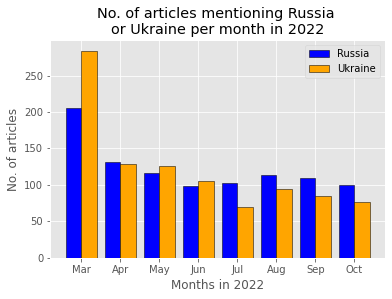

In [95]:
month_name = ['marec', 'april', 'maj', 'junij', 'julij', 'avgust', 'september', 'oktober']
month_rus = num_of_articles_per_month(data_rus)   
month_ukr = num_of_articles_per_month(data_ukr)

x_axis = np.arange(len(month_name))
 
# creating the bar plot
plt.bar(x_axis - 0.2, month_rus, color ='b', width = 0.4, edgecolor = 'black', label = 'Russia')
plt.bar(x_axis + 0.2, month_ukr, color ='orange', width = 0.4, edgecolor = 'black', label = 'Ukraine')
plt.xlabel("Months in 2022")
plt.ylabel("No. of articles")
plt.title("No. of articles mentioning Russia \nor Ukraine per month in 2022")
plt.xticks(x_axis, ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'])
plt.legend()
plt.show()

### Visualization 2

This pie chart shows the percentage of articles out of total number of articles parsed that refer to Ukraine only, Russia only and those that refer to the both keywords (overlapping articles). This chart shows that out of the total number of articles that ae obtained for the search terms 'ukrajina' and 'rusija', as many as 34.9% of the articles overlap. This means that from March 2022 till October 2022, these two terms appear more often together in the news, than each of them individually. The percentage of articles referring only to Ukraine or only to Russia is approximately the same (32.5% and 32.6%, respectively).

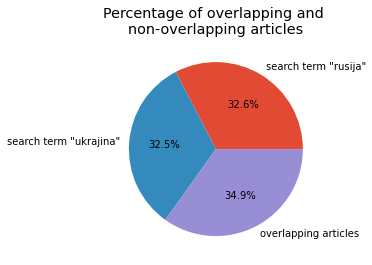

In [91]:
# Visualization 2 code

overlapping_art = 0
overlapping_index = []
for i in range(len(data_rus)):
    for j in range(len(data_ukr)):
        if data_rus[i]['title'] == data_ukr[j]['title']: # compares titles of the articles for search terms 'rusija' and 'ukrajina'
            overlapping_index.append(i)                  # makes a list of indexes of overlapping articles 
            overlapping_art += 1                         # counts articles that appear when searching with both keywords        

rus_art = len(data_rus) - overlapping_art                # articles that appear only when searching with the keyword 'rusija'
ukr_art = len(data_ukr) - overlapping_art                # articles that appear only when searching with the keyword 'ukrajina'
total = overlapping_art + rus_art + ukr_art              # total number of unique articles for keywords 'rusija' and 'ukrajina'

data = [rus_art, ukr_art, overlapping_art]
labels = ['search term "rusija"', 'search term "ukrajina"','overlapping articles']
plt.pie(data, labels = labels, autopct='%.1f%%')
plt.title('Percentage of overlapping and \nnon-overlapping articles')
plt.show()


In [90]:
# Removing the overlapping articles

data_rus_c = data_rus.copy()
for index in overlapping_index:
    data_rus_c[index] = 0                                # sets all overlapping articles in data_rus_c to 0

data_rus_no_overlap = [x for x in data_rus_c if x != 0]  # list of articles for search term 'rusija' excluding overlapping articles

no_overlap = data_ukr + data_rus_no_overlap              # merges the list of all articles with search term 'ukrajina' and the
print(len(no_overlap))                                   # list of articles with serach term 'rusija' with excluded overlapping articles

1472


### Visualization 3

This horizontal bar chart shows in how many articles, out of total 1472 non-overlapping aricles for search terms 'ukrajina' and
'rusija' are following political figures mentioned: Putin, Zelenski, Scholz, Biden, Lavrov, Macron, Erdogan, Golob, Pahor, Vučić and Orban. The graph shows that Putin is by far the most "popular" in the news, followed by Zelensky, Scholz and Biden.


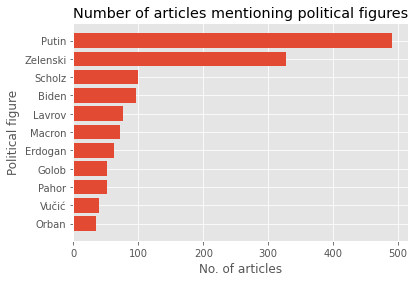

In [53]:
# Visualization 3 code

people = ['Orban','Vučić','Pahor','Golob','Erdogan','Macron','Lavrov','Biden','Scholz','Zelenski','Putin'] 
words_num = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
for i in range(0,len(no_overlap)):
    for j in people:
        if (j in no_overlap[i]['content']) == True:      # checks if the word from the people list is in the article, and if it is:
            k = people.index(j)                          # finds index of that word in the people list
            words_num[k] += 1                            # adds 1 to the same index in words_num

plt.style.use('ggplot')
plt.barh(people, words_num)
plt.title('Number of articles mentioning political figures')
plt.ylabel('Political figure')
plt.xlabel('No. of articles')
plt.show()

### Visualization 4

This bar plot shows the number of articles with and without video, and also, average number of comments and average length in words for these two classes. As expected, the majority of articles on the RTV Slo website do not have video, however, it's visible from this plot that articles with video have, on average, a lot more comments. Articles with and without video have approximately the same average length in words, a little over 500 words.

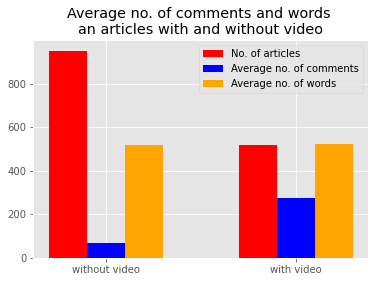

In [128]:
# Visualization 4 code

total_words = []
comments = []
total_words_v = []
comments_v = []

no_video = 0
video = 0
sum_len = 0
sum_len_v = 0
sum_comm = 0
sum_comm_v = 0

for i in range (0, len(no_overlap)):
    if no_overlap[i]['video(yes/no)'] == 'no':
        no_video += 1                                        # counts articles without video
        try:
            text = no_overlap[i]['content']
            l = len(text.split(' '))                         # splits text to words and finds the number of words in the article
            sum_len += l                                     # sums all lengths of articles without video
            total_words.append(l)                             
            comments.append(no_overlap[i]['comments_num'])
            sum_comm += no_overlap[i]['comments_num']        # sums all comments on articles without video
        except AttributeError:
            continue
    else:
        video += 1                                           # counts articles with video
        try:
            text_v = no_overlap[i]['content']
            l_v = len(text_v.split(' '))                     # splits text to words and finds the number of words in the article
            total_words_v.append(l)                             
            sum_len_v += l                                   # sums all lengths of articles without video
            comments_v.append(no_overlap[i]['comments_num']) # sums all comments on articles without video
            sum_comm_v += no_overlap[i]['comments_num'] 
        except AttributeError:
            continue


av_comm = [sum_comm/ no_video, sum_comm_v / video]            # average number of comments
av_len = [sum_len / no_video, sum_len_v/ video]               # average length in words
articles = [no_video, video]                                  # number of articles


# plotting bar chart
x_labels = ['without video', 'with video']
x_axis = np.arange(len(x_labels))
width = 0.2

bar1 = plt.bar(x_axis, articles, width, color='r')
bar2 = plt.bar(x_axis + width, av_comm, width, color = 'b')
bar3 = plt.bar(x_axis + width*2, av_len, width, color='orange')

plt.title("Average no. of comments and words \nan articles with and without video")
plt.xticks(x_axis + width, x_labels)
plt.legend( (bar1, bar2, bar3), ('No. of articles', 'Average no. of comments', 'Average no. of words') )
plt.show()

### Visualization 5

This bar plot shows the 18 most frequently used tags and the average number of comments on news with these tags.
It shows that readers on RTV Slo most often comment on the news that mention the Ukrainian and Russian president and military operations in Ukraine. They are less likely to comment on news that refer to gas, NATO, wheat, EU, Slovenia and sanctions, and the least likely to comment on news related to refugees and help.


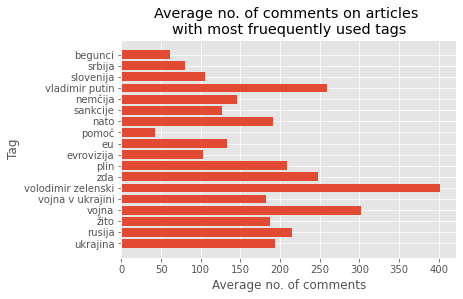

In [92]:
# Visualization 5 code

all_tags = []

# finding all tags
for i in range (0, len(no_overlap)):
    for t in no_overlap[i]['tags']:
        if t.lower() not in all_tags:
            all_tags.append(t.lower())

# counting occurance of each tag
zero_tags = [0]*len(all_tags)
for j in all_tags:
    for i in range (0, len(no_overlap)):
        if j in [x.lower() for x in no_overlap[i]['tags']]:
            tag_index = all_tags.index(j)
            zero_tags[tag_index] += 1
            
# finding total number of comments on all articles with a tag
zero_comm = [0]*len(all_tags)
for j in all_tags:
    for i in range (0, len(no_overlap)):
        if j in [x.lower() for x in no_overlap[i]['tags']]:
            tag_index = all_tags.index(j)
            zero_comm[tag_index] += no_overlap[i]['comments_num']

# finding average number  
average_comm = []
for x in range(0, len(zero_comm)):
    average_comm.append(zero_comm[x]/zero_tags[x])

# finding tags that occur more than 20 times
tags_comms = list(zip(all_tags, zero_tags, average_comm))
x = []
y = []
for k in range(len(tags_comms)):
    if tags_comms[k][1]>25:
        x.append(tags_comms[k][2])
        y.append(tags_comms[k][0])
        
# plotting
plt.style.use('ggplot')
plt.barh(y,x)
plt.title('Average no. of comments on articles \nwith most fruequently used tags')
plt.ylabel('Tag')
plt.xlabel('Average no. of comments')
plt.show()